## <span style="font-family: 'Times New Roman', serif; font-size: 50px; color: white;">Court Case Priority Ranker</span>

This notebook builds and evaluates a priority classification model to automatically prioritize legal case statements into their respective ranks (i.e `low,medium,high`). <br>
We built and tested different models during experimentation phase.After evaluation, we selected the best performing model i.e  `stacking classifier` built by ensembling ` SVC() `   and  `BernoulliNB()` and  `RandomForestClassifier()`.

#### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">Notebook Workflow:</span>

1. Imports used in notebook
2. Reading Data
3. Data Preprocessing
4. Model Building
5. Evaluation
6. Improvements
7. Web app building
    

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">1. Imports Used In Notebook:</span>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB,GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,precision_score,recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">2. Reading Data:</span>

The data is read from a csv file, named  `case_reports_priority.csv` located in the same directory as this notebook. It contains `2771` case statements along with their respective categories. The dataset has a shape of `(2771, 2)`, where one column represents the case `statement` and the other represents its `category`

In [54]:
dataset=pd.read_csv('case_reports_priority.csv')

In [55]:
dataset.shape

(2771, 2)

In [56]:
dataset.head(4)

,statement,priority
0,Challenge to 18th Amendment's Article 175A on ...,High
1,Civil appeal on Federal Service Tribunal judgm...,Medium
2,Supreme Court upholds interpleader suit mainta...,High
3,Civil Appeal: specific performance of 1973 pro...,Medium


### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">3. Data Preprocessing:</span>

 Steps: 

 1. Data Cleaning
 2. EDA
 3. Text Preprocessing (vectorization, stemming, removing stop words)

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(a) Data Cleaning:</span>

In [57]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  2738 non-null   object
 1   priority   2770 non-null   object
dtypes: object(2)
memory usage: 43.4+ KB


In [58]:
dataset.isnull().sum()

statement    33
priority      1
dtype: int64

In [59]:
dataset.dropna(inplace=True)

In [60]:
dataset.shape

(2738, 2)

In [61]:
dataset.isnull().sum()

statement    0
priority     0
dtype: int64

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(b) Exploratory Data Analysis:</span>

In [62]:
dataset['priority'].value_counts()

priority
High      1713
Medium     746
Low        279
Name: count, dtype: int64

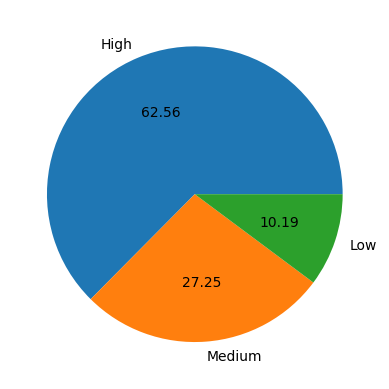

In [63]:
plt.pie(dataset['priority'].value_counts(), labels=['High','Medium','Low'],autopct='%0.2f')
plt.show()

The pie chart and the value counts of the priority column clearly show that the data is highly imbalanced. To address this issue, we perform upsampling to balance the priority categories, since we were unable to obtain additional data.

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">*      Upsampling:</span>

In [64]:
high = dataset[dataset['priority'] == 'High']
medium = dataset[dataset['priority'] == 'Medium']
low = dataset[dataset['priority'] == 'Low']

In [65]:
# Handling imbalance by oversampling Medium and Low
medium_upsampled = resample(medium, replace=True, n_samples=len(high), random_state=42)
low_upsampled = resample(low, replace=True, n_samples=len(high), random_state=42)

In [66]:
df_balanced = pd.concat([high, medium_upsampled, low_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [67]:
df_balanced.shape

(5139, 2)

In [68]:
df_balanced['priority'].value_counts()

priority
High      1713
Low       1713
Medium    1713
Name: count, dtype: int64

In [69]:
df_balanced['priority'].describe()

count     5139
unique       3
top       High
freq      1713
Name: priority, dtype: object

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(c) Text Preprocessing:</span>

In [ ]:
lemmatizer = WordNetLemmatizer()

In [71]:
# not needed on every run . 
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [72]:
corpus = []
for i in range(0, len(df_balanced)):
    review = re.sub('[^a-zA-Z0-9]', ' ', df_balanced['statement'].iloc[i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [73]:
corpus[90]

'civil petition land settlement dispute competency writ plaint rejection laches 32 year old order'

In [74]:
X = corpus

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">4. Model Building:</span>

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(a) Train Test Split:</span>

In [75]:
# first encode the textual output, i.e category, to labels
encoder = LabelEncoder()
y = encoder.fit_transform(df_balanced['priority'])
# X = corpus 

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(b) Pipeline Creation:</span>

We used TF-IDF vectorizer here for case category classification because it down-weights common legal terms and highlights the more informative words that help distinguish between categories.

<span style="font-family: 'Times New Roman', serif; font-size: 20px; color: white;">Model used in pipeline : Voting Classifier ( )</span>

We selected the `Stacking Classifier` combining two highly performing models i.e `SVC()`  and   `BernoulliNB()`, and `RandomForestClassifier() ` as final estimator, as it achieved the best overall performance in terms of recall, F1-score, and accuracy compared to other models.

The other models we trained are also included below in this notebook for reference, along with their output scores.

In [77]:
svc = SVC()
bernoulliNB = BernoulliNB()

In [78]:
estimators=[('svm', svc), ('nb', bernoulliNB)]
final_estimator=RandomForestClassifier()

In [79]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [80]:
stacking_pipeline= Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('stacking_classifier', stacking_clf)
])


### <span style="font-family: 'Times New Roman', serif; font-size: 28px; color: white;">(c) Model Training:</span>

In [81]:
stacking_pipeline.fit(X_train,y_train)

,steps,"[('tfidf', ...), ('stacking_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">5. Model Evaluation:</span>

Performance in terms of `recall`, `F1-score`, and `accuracy`

In [82]:
y_pred = stacking_pipeline.predict(X_test)

In [83]:
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')

Confusion Matrix
 [[315   0  27]
 [  0 341   2]
 [ 19   1 323]] 



In [84]:
print('Classification report\n',classification_report(y_test,y_pred))

Classification report
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       342
           1       1.00      0.99      1.00       343
           2       0.92      0.94      0.93       343

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



In [86]:
print('Train Accuracy',accuracy_score(y_train,stacking_pipeline.predict(X_train))*100)
print('Test Accuracy',accuracy_score(y_test,y_pred)*100)
print('Recall Score',recall_score(y_test,y_pred,average=None)*100)
print('F1 Score',f1_score(y_test,y_pred,average=None)*100)

Train Accuracy 99.73242520068109
Test Accuracy 95.23346303501945
Recall Score [92.10526316 99.41690962 94.16909621]
F1 Score [93.19526627 99.5620438  92.94964029]


### `Our Remarks on the Model`

Our model demonstrates strong performance with a `train accuracy` of `99.73%` and `test accuracy` of `95.23%`, showing good generalization and minimal(4 units) overfitting.
Class-wise `recall` and `F1` scores are consistently high, indicating that the model reliably identifies case categories across all classes.
Overall, these results highlight that our model is `robust`, and `accurate`.

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">6. Models We Tried While Building Our Final Model</span>

1. GaussianNB()
2. BernoulliNB()
3. MultinomialNB()

### 1. GaussianNB( )

In [87]:
# GaussianNB() 
pipe_gnb = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),   # GaussianNB expects dense input, while tfidf gives sparse array so .toarray() converts sparse array to dense array
    ('gaussianNB', GaussianNB())
])

In [88]:
pipe_gnb.fit(X_train,y_train)
y_pred1 = pipe_gnb.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,pipe_gnb.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred1))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred1),'\n')
print('Classification report\n',classification_report(y_test,y_pred1))
print("Recall :", recall_score(y_test, y_pred1,average=None))

Train Accuracy 0.9764047676964243
Test Accuracy 0.9270428015564203
Confusion Matrix
 [[293   0  49]
 [  0 342   1]
 [ 17   8 318]] 

Classification report
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       342
           1       0.98      1.00      0.99       343
           2       0.86      0.93      0.89       343

    accuracy                           0.93      1028
   macro avg       0.93      0.93      0.93      1028
weighted avg       0.93      0.93      0.93      1028

Recall : [0.85672515 0.99708455 0.9271137 ]


### `Remarks:`

GaussianNB( ) is performing good except that the recall score for category 0 is low


### 2. MultinomialNB( )

In [89]:
# MultinomialNB() 
from sklearn.preprocessing import FunctionTransformer
pipe_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('multinomialNB', MultinomialNB())
])

In [90]:
pipe_mnb.fit(X_train,y_train)
y_pred = pipe_mnb.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,pipe_mnb.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification report\n',classification_report(y_test,y_pred))
print("Recall :", recall_score(y_test, y_pred,average=None))

Train Accuracy 0.9211870591097057
Test Accuracy 0.8764591439688716
Confusion Matrix
 [[289   0  53]
 [  9 300  34]
 [ 26   5 312]] 

Classification report
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       342
           1       0.98      0.87      0.93       343
           2       0.78      0.91      0.84       343

    accuracy                           0.88      1028
   macro avg       0.89      0.88      0.88      1028
weighted avg       0.89      0.88      0.88      1028

Recall : [0.84502924 0.87463557 0.90962099]


### `Remarks:`

MultinomialNB( ) is performing bad at recall for two categories as well as the accuracy score is  also low

### 3. BernoulliNB( )

In [91]:
pipe_bnb = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('bernoulliNB', BernoulliNB())
])

In [92]:
pipe_bnb.fit(X_train,y_train)
y_pred = pipe_bnb.predict(X_test)
print('Train Accuracy',accuracy_score(y_train,pipe_bnb.predict(X_train)))
print('Test Accuracy',accuracy_score(y_test,y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification report\n',classification_report(y_test,y_pred))
print("Recall :", recall_score(y_test, y_pred,average=None))

Train Accuracy 0.9160788129408903
Test Accuracy 0.8715953307392996
Confusion Matrix
 [[291   0  51]
 [  8 289  46]
 [ 23   4 316]] 

Classification report
               precision    recall  f1-score   support

           0       0.90      0.85      0.88       342
           1       0.99      0.84      0.91       343
           2       0.77      0.92      0.84       343

    accuracy                           0.87      1028
   macro avg       0.89      0.87      0.87      1028
weighted avg       0.89      0.87      0.87      1028

Recall : [0.85087719 0.8425656  0.9212828 ]


### `Remarks:`

BernoulliNB( ) perfroms almost same as the MultinomialNB().


We use BernoulliNB( ) in stacking classifier to avoid overfitting

### <span style="font-family: 'Times New Roman', serif; font-size: 25px; color: white;">Hyperparameter Tuning Code</span>

In [93]:
tuning_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('bnb', BernoulliNB())
])

# Parameter grid 
param_grid = {
    # TfidfVectorizer
    'tfidf__ngram_range': [(1,1), (1,2)],        
    'tfidf__min_df': [1, 2],               
    'tfidf__max_df': [0.75, 0.9, 1.0],         
    'tfidf__use_idf': [True, False],                
    'tfidf__smooth_idf': [True, False], 
    'tfidf__sublinear_tf': [True, False],   

    # BernoulliNB hyperparams
    'bnb__alpha': [0.1, 0.5, 1.0],                       
    'bnb__fit_prior': [True, False],                    
    'bnb__binarize': [None, 0.0, 0.5]       
}

# Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV object
grid = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',   
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search
grid.fit(X_train, y_train)

# Best params / score
print("Best cross-val F1 (weighted):", grid.best_score_)
print("Best params:", grid.best_params_)

# Evaluate best model on test set
best = grid.best_estimator_
y_pred = best.predict(X_test)

print("\nTrain accuracy:", accuracy_score(y_train, best.predict(X_train)))
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred,average=None))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best cross-val F1 (weighted): 0.9439668971726342
Best params: {'bnb__alpha': 0.1, 'bnb__binarize': 0.0, 'bnb__fit_prior': True, 'tfidf__max_df': 0.75, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}

Train accuracy: 0.9924592556555583
Test accuracy : 0.9484435797665369
Recall : [0.90350877 0.98542274 0.95626822]

Confusion Matrix:
 [[309   0  33]
 [  3 338   2]
 [ 12   3 328]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9537    0.9035    0.9279       342
           1     0.9912    0.9854    0.9883       343
           2     0.9036    0.9563    0.9292       343

    accuracy                         0.9484      1028
   macro avg     0.9495    0.9484    0.9485      1028
weighted avg     0.9495    0.9484    0.9485      1028



### `Remarks:`

Hyperparameter tuned BernoulliNB() performs well on its own, but it still lags behind the Voting Classifier, which achieves high precision across all three categories.

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">4. Training 10 Models and evaluating their output</span>


In [94]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [95]:
clfs = {
    'Support Vector Classifier' : svc,
    'KNearest Neighbor' : knc, 
    'Decision Tree Classifier': dtc, 
    'Logistic Regression': lrc, 
    'Random Forest Classifier': rfc, 
    'AdaBoost': abc, 
    'Bagging ClassifierC': bc, 
    'Extra Trees Classifier': etc,
    'Gradient BoostingcClassifier':gbdt,
    'XGBoost Classifier':xgb
}

In [104]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf_pipeline=Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('classifier', clf)
    ])
    clf_pipeline.fit(X_train,y_train)
    y_pred = clf_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred,average='micro')
    cr = classification_report(y_test,y_pred)
    
    return accuracy,recall,cr

In [105]:
for name,clf in clfs.items():
    
    current_accuracy,current_recall,current_cr = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Recall - ",current_recall)
    print("Classification Report",current_cr)
    print('---------------'*9)

For  Support Vector Classifier
Accuracy -  0.8978599221789884
Recall -  0.8978599221789884
Classification Report               precision    recall  f1-score   support

           0       0.91      0.86      0.89       342
           1       0.95      0.95      0.95       343
           2       0.83      0.88      0.86       343

    accuracy                           0.90      1028
   macro avg       0.90      0.90      0.90      1028
weighted avg       0.90      0.90      0.90      1028

---------------------------------------------------------------------------------------------------------------------------------------
For  KNearest Neighbor
Accuracy -  0.6663424124513618
Recall -  0.6663424124513618
Classification Report               precision    recall  f1-score   support

           0       0.95      0.06      0.10       342
           1       0.98      0.96      0.97       343
           2       0.50      0.98      0.66       343

    accuracy                           0.67    

d:\judiciary and law project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


For  Logistic Regression
Accuracy -  0.8589494163424124
Recall -  0.8589494163424124
Classification Report               precision    recall  f1-score   support

           0       0.85      0.85      0.85       342
           1       0.94      0.92      0.93       343
           2       0.79      0.81      0.80       343

    accuracy                           0.86      1028
   macro avg       0.86      0.86      0.86      1028
weighted avg       0.86      0.86      0.86      1028

---------------------------------------------------------------------------------------------------------------------------------------
For  Random Forest Classifier
Accuracy -  0.9377431906614786
Recall -  0.9377431906614786
Classification Report               precision    recall  f1-score   support

           0       0.95      0.87      0.91       342
           1       0.99      1.00      1.00       343
           2       0.88      0.94      0.91       343

    accuracy                           0.94   

### `Remarks:` 

SVC( ) , ExtraTreesClassifier( ), RandomForestClassifier() , Bagging classifier and xgboost are the best performing models among all 10, but they lag behind the stacking classifier either in recall score or cause overfitting.

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">5. Training One more Model</span>

* Voting Classifier

### <span style="font-family: 'Times New Roman', serif; font-size: 25px; color: white;"> Voting Classifier</span>

In [98]:
support_vector_clf = SVC(kernel='sigmoid', gamma=1.0,probability=True)
bernoulliNB = BernoulliNB()
extra_tree_clf = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [99]:
voting_clf = VotingClassifier(estimators=[('svm', support_vector_clf), ('nb', bernoulliNB), ('et', extra_tree_clf)],voting='soft')

In [100]:
# pipeline
voting_pipeline= Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('voting_classifier', voting_clf)
])

In [101]:
voting_pipeline.fit(X_train,y_train)

,steps,"[('tfidf', ...), ('voting_classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [102]:
y_pred = voting_pipeline.predict(X_test)
print('Confusion Matrix\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification report\n',classification_report(y_test,y_pred))
print("Train accuracy:", accuracy_score(y_train, voting_pipeline.predict(X_train))*100)
print("Test accuracy :", accuracy_score(y_test, y_pred)*100)
print("Recall Score :", recall_score(y_test, y_pred,average=None)*100)

Confusion Matrix
 [[297   0  45]
 [  3 329  11]
 [ 15   2 326]] 

Classification report
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       342
           1       0.99      0.96      0.98       343
           2       0.85      0.95      0.90       343

    accuracy                           0.93      1028
   macro avg       0.93      0.93      0.93      1028
weighted avg       0.93      0.93      0.93      1028

Train accuracy: 96.78910240817319
Test accuracy : 92.60700389105058
Recall Score : [86.84210526 95.91836735 95.04373178]


### `Remarks:`

Voting classifier is performing well but lags behind stacking classifier in recall across category 1 and its accuracy is also low by 2 units then that of stacking classifier.

### <span style="font-family: 'Times New Roman', serif; font-size: 30px; color: white;">7. Web Application Development</span>

In [103]:
pickle.dump(stacking_pipeline,open('stacking_pipeline.pkl','wb'))
pickle.dump(encoder,open('label_encoder.pkl','wb'))